# Cluster Analysis

### Task Description
To better understand what typical charging sessions look like, carry out a cluster
analysis to provide management with a succinct report of archetypical charging events. Think of an
appropriate trade-off between explainability and information content and try to come up with names
for these clusters. What is the value of identifying different types of charging sessions?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data Prep

In [2]:
df_charging_sessions = pd.read_csv("charging_sessions_preprocessed.csv",  parse_dates=['connectionTime','disconnectTime','doneChargingTime']);
# convert to local time
df_charging_sessions["connectionTime"] = df_charging_sessions["connectionTime"].dt.tz_convert("America/Los_Angeles")
df_charging_sessions["disconnectTime"] = df_charging_sessions["disconnectTime"].dt.tz_convert("America/Los_Angeles")
df_charging_sessions["doneChargingTime"] = df_charging_sessions["doneChargingTime"].dt.tz_convert("America/Los_Angeles")
print(df_charging_sessions.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60921 entries, 0 to 60920
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype                              
---  ------               --------------  -----                              
 0   id                   60921 non-null  object                             
 1   connectionTime       60921 non-null  datetime64[ns, America/Los_Angeles]
 2   disconnectTime       60921 non-null  datetime64[ns, America/Los_Angeles]
 3   doneChargingTime     60921 non-null  datetime64[ns, America/Los_Angeles]
 4   kWhDelivered         60921 non-null  float64                            
 5   sessionID            60921 non-null  object                             
 6   siteID               60921 non-null  int64                              
 7   spaceID              60921 non-null  object                             
 8   stationID            60921 non-null  object                             
 9   userID               44636 n

For the cluster analysis, we include the weather data as it could provide important information about the types of charging sessions.
We merge the two datasets based on the day and hour the charging session started, as we only have hourly information about the weather. We analyse the temperature and the description of the cloud cover. With this information, we know if, for example, it was cold and rainy during a charging session.

In [4]:
# read in weather data
weather_set = pd.read_csv('weather_burbank_airport_preprocessed.csv', parse_dates=['timestamp'])
weather_set['timestamp'] = pd.to_datetime(weather_set['timestamp']).dt.tz_localize('UTC').dt.tz_convert('America/Los_Angeles')
print(weather_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29244 entries, 0 to 29243
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype                              
---  ------                   --------------  -----                              
 0   timestamp                29244 non-null  datetime64[ns, America/Los_Angeles]
 1   temperature              29244 non-null  float64                            
 2   cloud_cover              29244 non-null  float64                            
 3   cloud_cover_description  29244 non-null  object                             
 4   pressure                 29244 non-null  float64                            
 5   windspeed                29244 non-null  float64                            
 6   precipitation            29244 non-null  float64                            
 7   felt_temperature         29244 non-null  float64                            
dtypes: datetime64[ns, America/Los_Angeles](1), float64(6), object(1)
me

In [5]:
# drop columns that are not needed
weather_set = weather_set.drop(['cloud_cover', 'cloud_cover_description','pressure', 'windspeed', 'felt_temperature'], axis=1)
print(weather_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29244 entries, 0 to 29243
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype                              
---  ------         --------------  -----                              
 0   timestamp      29244 non-null  datetime64[ns, America/Los_Angeles]
 1   temperature    29244 non-null  float64                            
 2   precipitation  29244 non-null  float64                            
dtypes: datetime64[ns, America/Los_Angeles](1), float64(2)
memory usage: 685.5 KB
None


In [6]:
# create dataframe for hourly weather data

weather_set['connectionDate'] = weather_set['timestamp'].dt.date
weather_set['connectionHour'] = weather_set['timestamp'].dt.hour
days_unique = weather_set['connectionDate'].unique()
days = np.repeat(days_unique,24)
hours = list(range(0,24))
hours = hours*len(days_unique)

weather_hourly = pd.DataFrame()
weather_hourly['connectionDate'] = days
weather_hourly['connectionHour'] = hours
print(len(weather_hourly))
print(weather_hourly)

26280
      connectionDate  connectionHour
0         2018-01-01               0
1         2018-01-01               1
2         2018-01-01               2
3         2018-01-01               3
4         2018-01-01               4
...              ...             ...
26275     2020-12-31              19
26276     2020-12-31              20
26277     2020-12-31              21
26278     2020-12-31              22
26279     2020-12-31              23

[26280 rows x 2 columns]


In [7]:
# add columns temperature and precipitation
# if they are several values for an hour of a day, mean is caluclated
temperature = []
precipitation = []
for index, row in weather_hourly.iterrows():
    searched_day = row['connectionDate']
    searched_hour = row['connectionHour']
    temperatures_of_hour = weather_set[(weather_set['connectionDate']==searched_day) & (weather_set['connectionHour']==searched_hour)]['temperature']
    temperature.append(temperatures_of_hour.mean())
    precipitation_of_hour = weather_set[(weather_set['connectionDate']==searched_day) & (weather_set['connectionHour']==searched_hour)]['precipitation']
    precipitation.append(precipitation_of_hour.mean())

weather_hourly['temperature'] = temperature
weather_hourly['precipitation'] = precipitation
print(weather_hourly.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   connectionDate  26280 non-null  object 
 1   connectionHour  26280 non-null  int64  
 2   temperature     26210 non-null  float64
 3   precipitation   26210 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 821.4+ KB
None


We have some Null values for temperature and perceptibility. This is due to missing data in the weather dataset. The set does not contain information for every hour of every day. To fill in these gaps, we use the value from the hour before.

In [8]:
weather_hourly_cleaned = weather_hourly.copy()
weather_hourly_cleaned['temperature'] = weather_hourly['temperature'].fillna(method='ffill')
weather_hourly_cleaned['precipitation'] = weather_hourly['precipitation'].fillna(method='ffill')
print(weather_hourly_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   connectionDate  26280 non-null  object 
 1   connectionHour  26280 non-null  int64  
 2   temperature     26280 non-null  float64
 3   precipitation   26280 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 821.4+ KB
None


In [9]:
# add columns for merging
df_charging_sessions['connectionDate'] = df_charging_sessions['connectionTime'].dt.date
df_charging_sessions['connectionHour'] = df_charging_sessions['connectionTime'].dt.hour

In [10]:
# left merge
df_charging_sessions_weather = df_charging_sessions.merge(weather_hourly_cleaned, how='left', on=['connectionDate', 'connectionHour'])
print(df_charging_sessions_weather.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60921 entries, 0 to 60920
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype                              
---  ------               --------------  -----                              
 0   id                   60921 non-null  object                             
 1   connectionTime       60921 non-null  datetime64[ns, America/Los_Angeles]
 2   disconnectTime       60921 non-null  datetime64[ns, America/Los_Angeles]
 3   doneChargingTime     60921 non-null  datetime64[ns, America/Los_Angeles]
 4   kWhDelivered         60921 non-null  float64                            
 5   sessionID            60921 non-null  object                             
 6   siteID               60921 non-null  int64                              
 7   spaceID              60921 non-null  object                             
 8   stationID            60921 non-null  object                             
 9   userID               44636 n

In [11]:
print(df_charging_sessions_weather[df_charging_sessions_weather['temperature'].isnull()]['connectionDate'])
print(df_charging_sessions_weather['connectionDate'].max())

13861    2021-01-03
13862    2021-01-03
13863    2021-01-04
13864    2021-01-04
13865    2021-01-04
            ...    
46714    2021-09-13
46715    2021-09-13
46716    2021-09-13
46717    2021-09-13
46718    2021-09-13
Name: connectionDate, Length: 7452, dtype: object
2021-09-13


The weather data set contains a shorter time frame than the charging session set. Thus, we only look a the time frame which is included in both of them.

In [12]:
# not all the dates are covered with the weather data
# shorten the dataframe we look at
df_charging_sessions_weather_short = df_charging_sessions_weather[df_charging_sessions_weather['temperature'].notnull()]
print(df_charging_sessions_weather_short.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53469 entries, 0 to 60920
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype                              
---  ------               --------------  -----                              
 0   id                   53469 non-null  object                             
 1   connectionTime       53469 non-null  datetime64[ns, America/Los_Angeles]
 2   disconnectTime       53469 non-null  datetime64[ns, America/Los_Angeles]
 3   doneChargingTime     53469 non-null  datetime64[ns, America/Los_Angeles]
 4   kWhDelivered         53469 non-null  float64                            
 5   sessionID            53469 non-null  object                             
 6   siteID               53469 non-null  int64                              
 7   spaceID              53469 non-null  object                             
 8   stationID            53469 non-null  object                             
 9   userID               37600 n

The Data must only contain numeric values so that we can use it for Clustering.

In [13]:
# drop id
df_charging_sessions_weather_short = df_charging_sessions_weather_short.drop(['id'], axis=1)

In [14]:
# connectionTime, disconnectTime and doneChargingTime are transformed into seconds after midnight.
df_charging_sessions_weather_short['connectionTime'] = df_charging_sessions_weather_short['connectionTime'].dt.hour * 3600 + df_charging_sessions_weather_short['connectionTime'].dt.minute * 60 + df_charging_sessions_weather_short['connectionTime'].dt.second
df_charging_sessions_weather_short['disconnectTime'] = df_charging_sessions_weather_short['disconnectTime'].dt.hour * 3600 + df_charging_sessions_weather_short['disconnectTime'].dt.minute * 60 + df_charging_sessions_weather_short['disconnectTime'].dt.second
df_charging_sessions_weather_short['doneChargingTime'] = df_charging_sessions_weather_short['doneChargingTime'].dt.hour * 3600 + df_charging_sessions_weather_short['doneChargingTime'].dt.minute * 60 + df_charging_sessions_weather_short['doneChargingTime'].dt.second
print(df_charging_sessions_weather_short.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53469 entries, 0 to 60920
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   connectionTime       53469 non-null  int64  
 1   disconnectTime       53469 non-null  int64  
 2   doneChargingTime     53469 non-null  int64  
 3   kWhDelivered         53469 non-null  float64
 4   sessionID            53469 non-null  object 
 5   siteID               53469 non-null  int64  
 6   spaceID              53469 non-null  object 
 7   stationID            53469 non-null  object 
 8   userID               37600 non-null  float64
 9   userInputs           37600 non-null  object 
 10  totalConnectionTime  53469 non-null  object 
 11  totalChargingTime    53469 non-null  object 
 12  userInformation      53469 non-null  bool   
 13  connectionDate       53469 non-null  object 
 14  connectionHour       53469 non-null  int64  
 15  temperature          53469 non-null 

In [15]:
# drop column sessionID, spaceID, stationID, userID, userInputs
df_charging_sessions_weather_short = df_charging_sessions_weather_short.drop(['sessionID', 'spaceID', 'stationID', 'userID', 'userInputs','connectionDate','connectionDate','connectionHour'], axis=1)
print(df_charging_sessions_weather_short.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53469 entries, 0 to 60920
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   connectionTime       53469 non-null  int64  
 1   disconnectTime       53469 non-null  int64  
 2   doneChargingTime     53469 non-null  int64  
 3   kWhDelivered         53469 non-null  float64
 4   siteID               53469 non-null  int64  
 5   totalConnectionTime  53469 non-null  object 
 6   totalChargingTime    53469 non-null  object 
 7   userInformation      53469 non-null  bool   
 8   temperature          53469 non-null  float64
 9   precipitation        53469 non-null  float64
dtypes: bool(1), float64(3), int64(4), object(2)
memory usage: 4.1+ MB
None


In [16]:
# totalConnectionTime and totalChargingTime into seconds
df_charging_sessions_weather_short['totalConnectionTime'] = pd.to_timedelta(df_charging_sessions_weather_short['totalConnectionTime'])
df_charging_sessions_weather_short['totalConnectionTime'] = df_charging_sessions_weather_short['totalConnectionTime'].dt.total_seconds()
df_charging_sessions_weather_short['totalChargingTime'] = pd.to_timedelta(df_charging_sessions_weather_short['totalChargingTime'])
df_charging_sessions_weather_short['totalChargingTime'] = df_charging_sessions_weather_short['totalChargingTime'].dt.total_seconds()
print(df_charging_sessions_weather_short.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53469 entries, 0 to 60920
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   connectionTime       53469 non-null  int64  
 1   disconnectTime       53469 non-null  int64  
 2   doneChargingTime     53469 non-null  int64  
 3   kWhDelivered         53469 non-null  float64
 4   siteID               53469 non-null  int64  
 5   totalConnectionTime  53469 non-null  float64
 6   totalChargingTime    53469 non-null  float64
 7   userInformation      53469 non-null  bool   
 8   temperature          53469 non-null  float64
 9   precipitation        53469 non-null  float64
dtypes: bool(1), float64(5), int64(4)
memory usage: 4.1 MB
None


In [18]:
df_charging_sessions_weather_short = df_charging_sessions_weather_short.drop(['connectionTime','totalChargingTime', 'disconnectTime', 'doneChargingTime','siteID','userInformation'], axis=1)

Now, we will scale the data.

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
scaler = StandardScaler()
scaler.fit(df_charging_sessions_weather_short)
charging_sessions_scaled = scaler.transform(df_charging_sessions_weather_short)

# create a df out of array
df_charging_sessions_scaled = pd.DataFrame(charging_sessions_scaled, columns=df_charging_sessions_weather_short.columns, index=df_charging_sessions_weather_short.index)
df_charging_sessions_scaled.head()

,kWhDelivered,totalConnectionTime,temperature,precipitation
0,1.327470,-0.091122,-0.791983,-0.109407
1,2.123623,0.506618,-0.791983,-0.109407
2,-0.494685,0.844467,-0.791983,-0.109407
3,-0.905126,-0.770601,-0.791983,-0.109407
4,0.180581,0.330243,-0.639367,-0.109407


In [28]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

We now use the K-means algorithm to find clusters in the data set. By applying the 'elbow' method, we try to find a good number of clusters. 

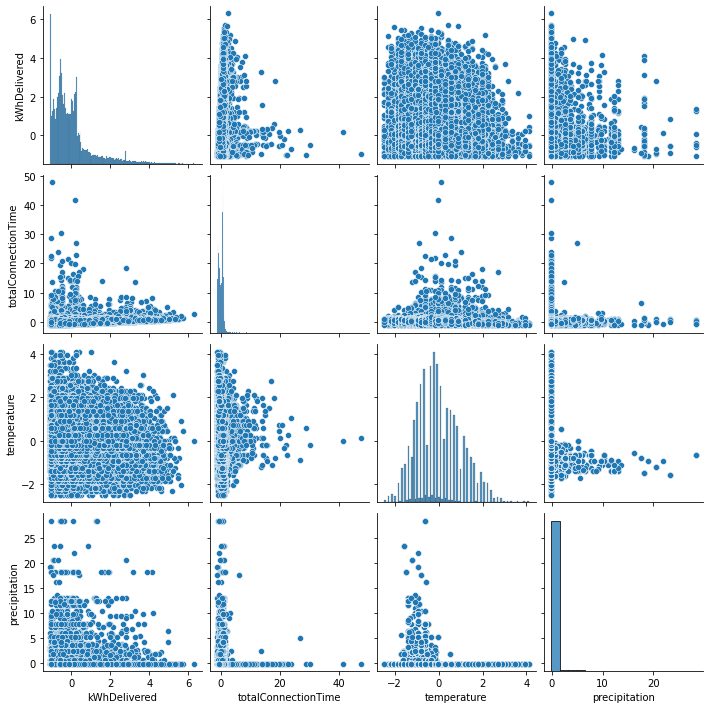

In [21]:
sns.pairplot(data=df_charging_sessions_scaled)

In [3]:
from sklearn.cluster import KMeans

In [22]:
# defining the max number of clusters
k_max = 40

# aplying k-means iteratively to figure out the best k
clusters = []
losses = []

for k in range(k_max):
    kmeans_model = KMeans(n_clusters=k+1)
    kmeans_model.fit(charging_sessions_scaled)
    clusters.append(k+1)
    losses.append(kmeans_model.inertia_)

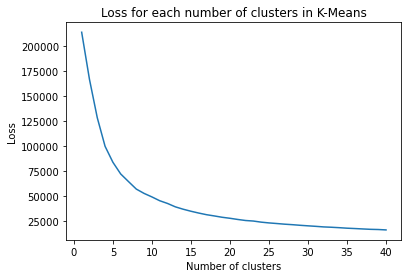

In [24]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.title("Loss for each number of clusters in K-Means")
plt.show()

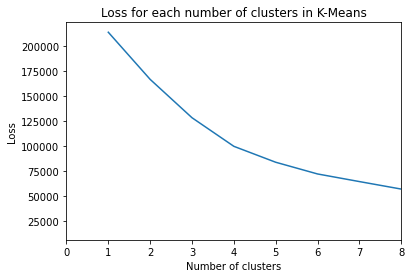

In [25]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.title("Loss for each number of clusters in K-Means")
plt.xlim([0,8])
plt.show()

A good number of cluster appears to lie between 3 and 6.

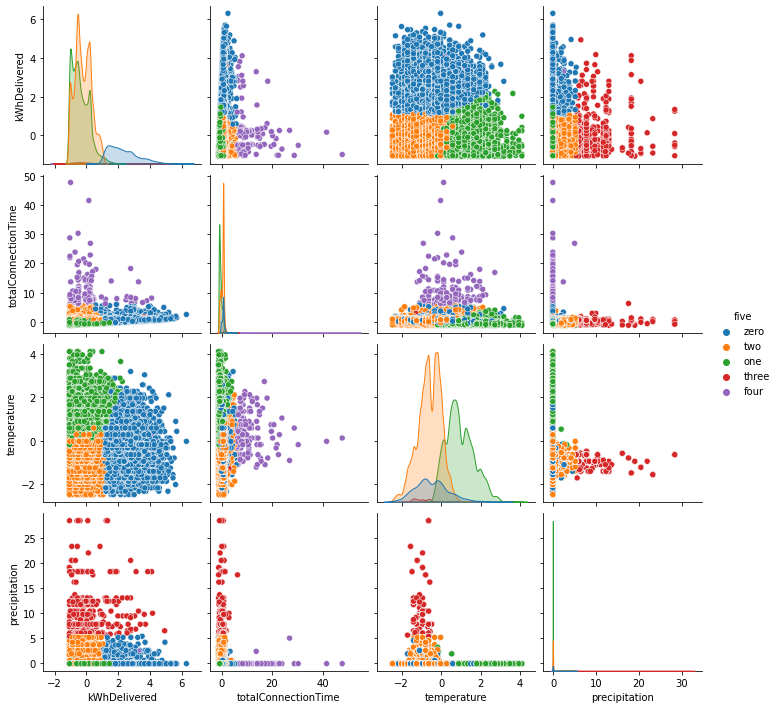

In [26]:
numbers = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight"]

five_means = KMeans(n_clusters=5)
five_means.fit(charging_sessions_scaled)
df_charging_sessions_scaled["five"] = five_means.predict(charging_sessions_scaled)
df_charging_sessions_scaled["five"] = df_charging_sessions_scaled["five"].apply(lambda x: numbers[x])
sns.pairplot(data=df_charging_sessions_scaled, hue="five")

5 possible cluster names:
- Blue: High Energy Charging
- Orange: Cold Quick Charging
- Green: Sunny Quick Charging
- Red: Weather-Responsive Charging
- Purple: Mixed Efficiency Charging

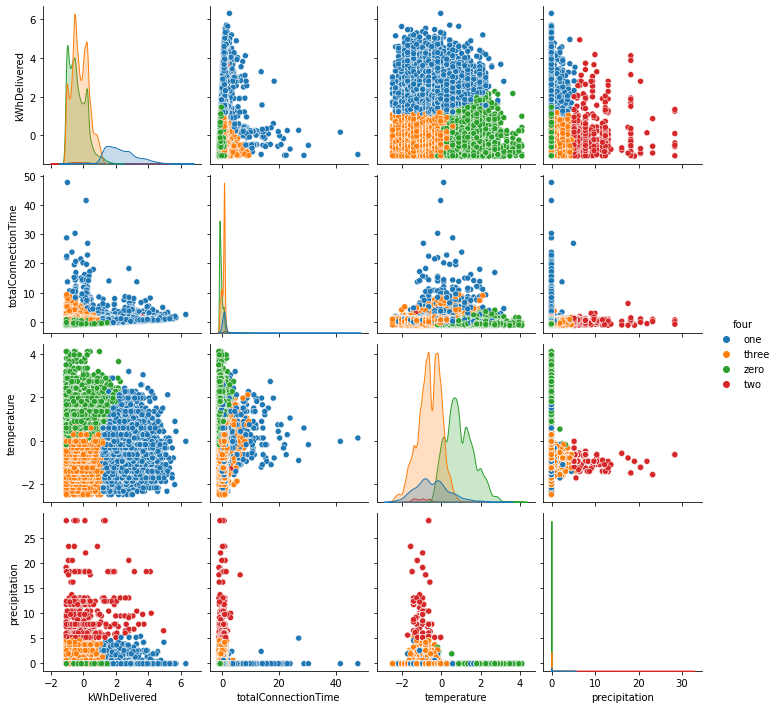

In [27]:
numbers = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight"]

four_means = KMeans(n_clusters=4)
four_means.fit(charging_sessions_scaled)
df_charging_sessions_scaled["four"] = four_means.predict(charging_sessions_scaled)
df_charging_sessions_scaled["four"] = df_charging_sessions_scaled["four"].apply(lambda x: numbers[x])
sns.pairplot(data=df_charging_sessions_scaled, hue="four")

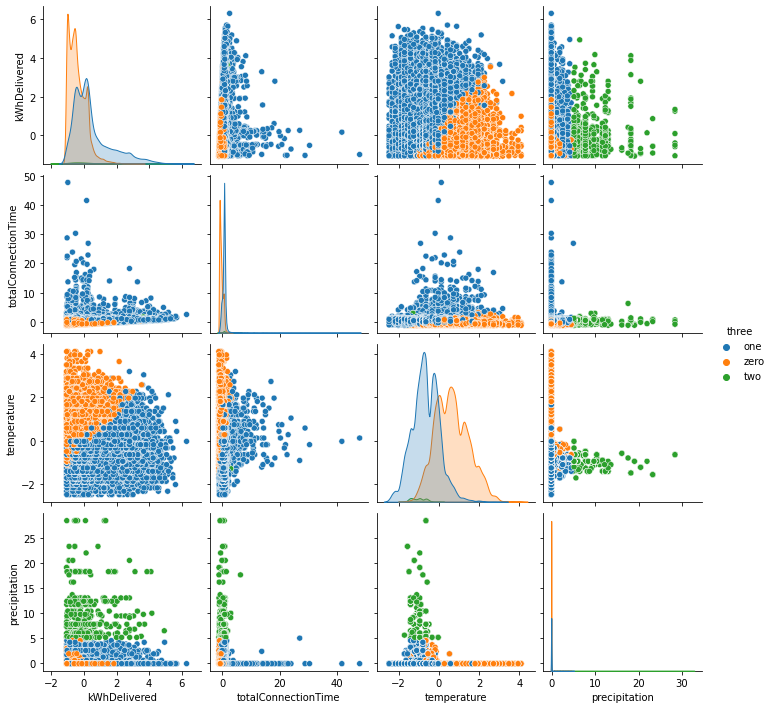

In [31]:
numbers = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight"]

three_means = KMeans(n_clusters=3)
three_means.fit(charging_sessions_scaled)
df_charging_sessions_scaled["three"] = three_means.predict(charging_sessions_scaled)
df_charging_sessions_scaled["three"] = df_charging_sessions_scaled["three"].apply(lambda x: numbers[x])
sns.pairplot(data=df_charging_sessions_scaled, hue="three")

When comparing the results, five clusters appear to be a good amount. Three and four appear too general, as some features of the clusters cover most of their value ranges. 